In [10]:
pip install pymysql


Note: you may need to restart the kernel to use updated packages.


In [28]:
pip install tensorflow


Note: you may need to restart the kernel to use updated packages.


In [15]:
import pymysql

try:
    connection = pymysql.connect(
        host='localhost',         # or use '127.0.0.1'
        user='root',
        password='Arashev3211!',
        database='nashville_housing',
        port=3306                 # Ensure this matches your MySQL configuration
    )
    print("Connection successful!")

    # Create a cursor to interact with the database
    with connection.cursor() as cursor:
        # Example query
        cursor.execute("SHOW TABLES;")
        tables = cursor.fetchall()
        print("Tables in the database:", tables)

    # Commit changes if any (optional, for transactions)
    connection.commit()

except pymysql.MySQLError as e:
    print("Error connecting to MySQL:", e)
finally:
    # Ensure the connection is closed
    if connection:
        connection.close()
        print("Connection closed!")


Connection successful!
Tables in the database: (('acreage_ranges',), ('cities',), ('features',), ('highvaluesalesbypropertytypeandcity',), ('land_use_mapping',), ('owners',), ('ownerships',), ('predictions',), ('properties',), ('recenthighvaluesales',), ('recentsales',), ('sales',), ('salestrends',), ('undervaluedpropertiesview',), ('valuation',), ('yearlypropertyappreciation',))
Connection closed!


In [29]:
import pymysql
import pandas as pd
from sklearn.preprocessing import StandardScaler
import tensorflow as tf

# MySQL connection configuration
db_config = {
    'host': 'localhost',
    'user': 'root',
    'password': 'Arashev3211!',
    'database': 'nashville_housing',
    'port': 3306
}

def fetch_data(query):
    """Fetch data from MySQL based on the query."""
    try:
        connection = pymysql.connect(**db_config)
        print("Connected to MySQL successfully!")
        data = pd.read_sql(query, connection)
        print(f"Data fetched successfully! {len(data)} records retrieved.")
        return data
    except pymysql.MySQLError as e:
        print("Error fetching data from MySQL:", e)
        exit()
    finally:
        if connection:
            connection.close()
            print("Connection closed!")

def preprocess_data(data, selected_features):
    """Preprocess data for the model."""
    X = data[selected_features].values
    y_actual = data['sale_price'].values
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    print("Data preprocessing completed!")
    return X_scaled, y_actual

def define_model(input_shape):
    """Define the structure of the ANN model."""
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=(input_shape,)),
        tf.keras.layers.Dense(units=128, activation='relu'),
        tf.keras.layers.Dense(units=64, activation='relu'),
        tf.keras.layers.Dense(units=32, activation='relu'),
        tf.keras.layers.Dense(units=1, activation='linear')  # Regression output
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
                  loss='mean_squared_error', 
                  metrics=['mae'])
    print("Model defined and compiled successfully!")
    return model

def train_model(model, X_scaled, y_actual):
    """Train the ANN model."""
    print("Training the model...")
    model.fit(X_scaled, y_actual, batch_size=32, epochs=50, verbose=1)
    print("Model training completed!")
    return model

def save_model(model, path):
    """Save the trained model."""
    model.save(path)
    print(f"Model saved successfully to {path}")

def load_model(path):
    """Load the trained model."""
    try:
        model = tf.keras.models.load_model(path)
        print("Model loaded successfully!")
        return model
    except Exception as e:
        print("Error loading the model:", e)
        exit()

def insert_predictions(data, predicted_prices, y_actual):
    """Insert or update predictions in the MySQL database."""
    try:
        connection = pymysql.connect(**db_config)
        print("Reconnected to MySQL!")

        # Prepare data for batch insertion
        predictions_data = [
            (int(row['property_id']), float(predicted_prices[i][0]), float(y_actual[i]))
            for i, row in data.iterrows()
        ]

        # Insert data into predictions table
        with connection.cursor() as cursor:
            cursor.executemany("""
                INSERT INTO predictions (property_id, predicted_sale_price, actual_sale_price)
                VALUES (%s, %s, %s)
                ON DUPLICATE KEY UPDATE 
                    predicted_sale_price = VALUES(predicted_sale_price),
                    actual_sale_price = VALUES(actual_sale_price)
            """, predictions_data)

            # Commit the transaction
            connection.commit()
            print(f"{cursor.rowcount} predictions inserted/updated successfully!")
    except pymysql.MySQLError as e:
        print("Error inserting predictions into MySQL:", e)
    finally:
        if connection:
            connection.close()
            print("Connection closed!")

# Main Workflow
if __name__ == "__main__":
    # SQL query to fetch data
    query = """
        SELECT 
            p.property_id,
            v.total_value, 
            v.building_value, 
            v.land_value, 
            f.bedrooms, 
            f.full_bath, 
            f.half_bath, 
            f.year_built,
            s.sale_price
        FROM properties p
        JOIN valuation v ON p.property_id = v.property_id
        JOIN features f ON p.property_id = f.property_id
        JOIN sales s ON p.property_id = s.property_id;
    """

    # Step 1: Fetch data
    data = fetch_data(query)

    # Step 2: Preprocess data
    selected_features = ['total_value', 'building_value', 'land_value', 
                         'bedrooms', 'full_bath', 'half_bath', 'year_built']
    X_scaled, y_actual = preprocess_data(data, selected_features)

    # Step 3: Define, train, and save the model
    model = define_model(X_scaled.shape[1])
    model = train_model(model, X_scaled, y_actual)
    save_model(model, 'nashville_ann_model.h5')

    # Step 4: Load the model and generate predictions
    loaded_model = load_model('nashville_ann_model.h5')
    predicted_prices = loaded_model.predict(X_scaled)
    print(f"Predictions generated for {len(predicted_prices)} records.")

    # Step 5: Insert predictions into MySQL
    insert_predictions(data, predicted_prices, y_actual)


Connected to MySQL successfully!


C:\Users\Jepbar\AppData\Local\Temp\ipykernel_2380\3842151059.py:20: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data = pd.read_sql(query, connection)


Data fetched successfully! 51076 records retrieved.
Connection closed!
Data preprocessing completed!
Model defined and compiled successfully!
Training the model...
Epoch 1/50
1597/1597 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 110177992704.0000 - mae: 209038.7344
Epoch 2/50
1597/1597 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 34013329408.0000 - mae: 107729.4141
Epoch 3/50
1597/1597 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 35432968192.0000 - mae: 102310.1406
Epoch 4/50
1597/1597 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 37397766144.0000 - mae: 101429.1016
Epoch 5/50
1597/1597 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 41008160768.0000 - mae: 102009.6016
Epoch 6/50
1597/1597 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 35525738496.0000 - mae: 99624.0234
Epoch 7/50
1597/1597 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 32546549760.0000 - mae: 99138.1406
Epoch 8/50
1597/1597 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 37253562368.0000 - mae: 100266.1875
Epoch 9/50
1597/1597 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step

Model training completed!
Model saved successfully to nashville_ann_model.h5


Model loaded successfully!
1597/1597 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
Predictions generated for 51076 records.
Reconnected to MySQL!
49648 predictions inserted/updated successfully!
Connection closed!


In [33]:
model.save('nashville_ann_model.keras')



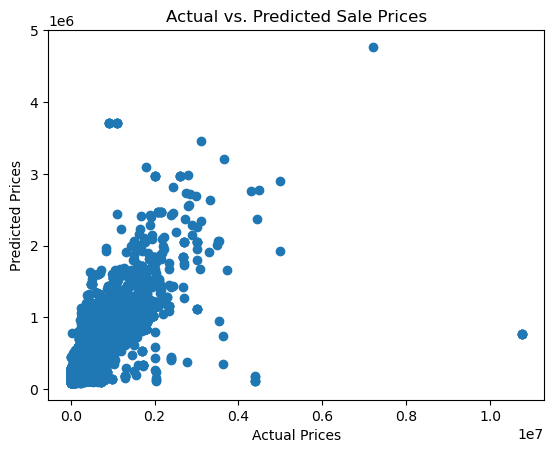

In [37]:
import matplotlib.pyplot as plt
plt.scatter(y_actual, predicted_prices)
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Actual vs. Predicted Sale Prices")
plt.show()


In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


In [41]:
import pymysql

# MySQL connection configuration
db_config = {
    'host': 'localhost',
    'user': 'root',
    'password': 'Arashev3211!',
    'database': 'nashville_housing',
    'port': 3306
}

# Fetch predictions
try:
    connection = pymysql.connect(**db_config)
    print("Connected to MySQL successfully!")

    query = "SELECT * FROM predictions;"
    predictions_data = pd.read_sql(query, connection)
    print("Predictions data fetched successfully!")

    connection.close()

except pymysql.MySQLError as e:
    print("Error fetching data from MySQL:", e)


Connected to MySQL successfully!


C:\Users\Jepbar\AppData\Local\Temp\ipykernel_2380\4012999079.py:18: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  predictions_data = pd.read_sql(query, connection)


Predictions data fetched successfully!


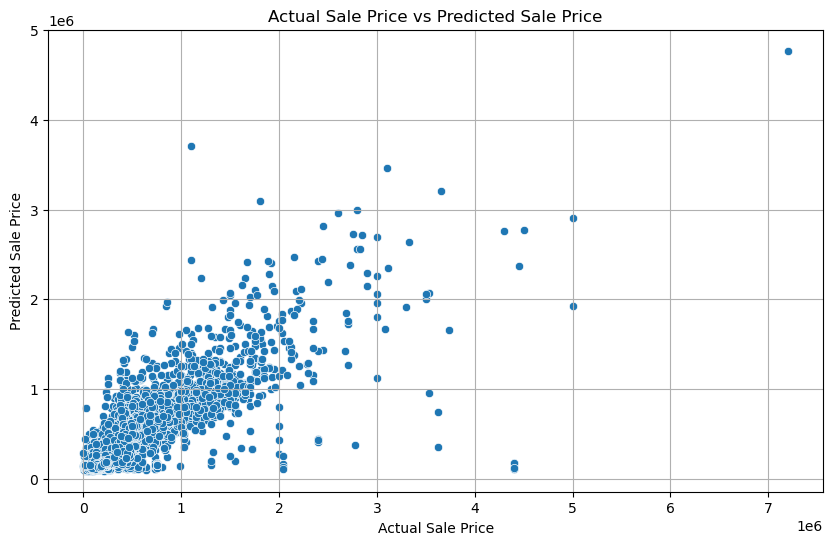

In [43]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=predictions_data['actual_sale_price'], y=predictions_data['predicted_sale_price'])
plt.title('Actual Sale Price vs Predicted Sale Price')
plt.xlabel('Actual Sale Price')
plt.ylabel('Predicted Sale Price')
plt.grid(True)
plt.show()



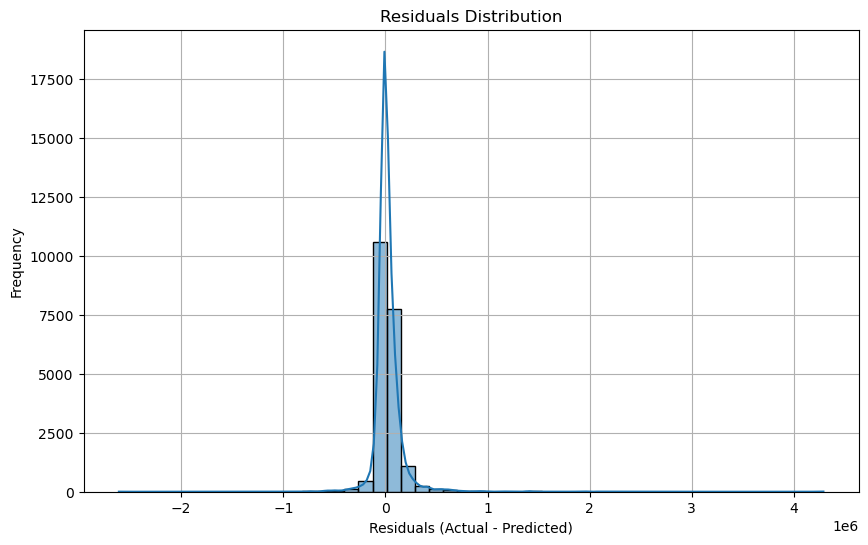

In [45]:
residuals = predictions_data['actual_sale_price'] - predictions_data['predicted_sale_price']
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, bins=50)
plt.title('Residuals Distribution')
plt.xlabel('Residuals (Actual - Predicted)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


In [59]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(predictions_data['actual_sale_price'], predictions_data['predicted_sale_price'])
mse = mean_squared_error(predictions_data['actual_sale_price'], predictions_data['predicted_sale_price'])
rmse = mse ** 0.5

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")


Mean Absolute Error (MAE): 74415.86575873599
Mean Squared Error (MSE): 26567729903.460358
Root Mean Squared Error (RMSE): 162996.10395178272
